# UNIDAD 3: Clasificación de texto


En este notebook vamos a ver tres enfoques para clasificar/agrupar un conjunto de textos:

- 3.1 Clasificación supervisada:
- 3.1.1 Clasificación binaria
- 3.1.2 Clasificación multiclase
- 3.2 Clasificación no supervisada (clustering).


## 3.1. Clasificación supervisada

### 3.1.1. Clasificación binaria

Para este primer caso vamos a trabajar con el dataset de ham/spam que ya lo habíamos visto antes.


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)

#### Paso 1: Carga del dataset

In [3]:

# Cargar el dataset:
data = pd.read_csv("../spam.csv",encoding="ISO-8859-1",
                   header=None, skiprows=1,
                   names = ["target", "text", "v3", "v4", "v5"])

#Ampliación de ancho del display para ver mejor el texto de la columna de mensajes.
pd.set_option('display.max_colwidth', 300)

#Usar las dos primeras columnas y renombrarlas:
data= data [['target','text']]
data.sample(5, random_state=42)


,target,text
3245,ham,"Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens"
944,ham,"I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones"
1044,spam,"We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p"
2484,ham,Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.
812,spam,Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16


#### Paso 2: Limpieza de texto

In [6]:
# Importar librerías necesarias:

import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import string
from nltk.stem import WordNetLemmatizer


def remove_urls(text):
	#Quitar URLs
	url_pattern = re.compile(r'https?://\S+|www\.\S+')
	return url_pattern.sub(r'', text)

def remove_emoji(text):
	# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtags_mentions(text):
    # Expresión regular para eliminar hashtags y menciones
    text_cleaned = re.sub(r'[@#]\w+', '', text)
    # Elimina espacios adicionales que pudieran quedar tras la limpieza
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned).strip()
    return text_cleaned

def remove_html(text):
	#Limpiar código HTML
    return BeautifulSoup(text, "lxml").text


def remove_punctuation(text, punctuation):
    #Verificar letra a letra y juntar todo el texto
    punctuationfree = "".join([i for i in text if i not in string.punctuation]) 
    return punctuationfree

def remove_numbers(text):
    """ Remover números """
    text = ''.join([i for i in text if not i.isdigit()])
    return text

def replace_strings(text, patterns):
	# Reemplazar ciertas cadenas de texto por otras
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text) #specifies strings or a set of strings or patterns that match it
    return text


#defining the function to remove stopwords from tokenized te
def remove_stopwords(text, stopwords):
    output= [i for i in text if i not in stopwords]
    return output

def stemming_es(token):
	# stemming the texto en español:
    es_stemmer = SnowballStemmer('spanish') # for english
    return es_stemmer.stem(token) # Para una palabra en español
     

def stemming_eng(text):
	# stemming the texto en inglés:
    eng_stemmer = PorterStemmer() # for english
    stem_text = [eng_stemmer.stem(word) for word in text]
    return stem_text

def lemmatizer_eng(text, wordnet_lemmatizer):
	#defining the function for lemmatization:
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

In [8]:
# Aplicar tareas de limpieza de texto que hagan falta:

#Convertir el texto en minúsculas:
data['clean_text']= data['text'].apply(lambda x: x.lower())
data.sample(5)

#Eliminar URLs:
data['clean_text']= data['clean_text'].apply(lambda x:remove_urls(x))

#Eliminar signos de puntuación:
PUNCTUATION = """!"#$%&()*+,-./:;<=>?@[\]^_`{|}~"""
data['clean_text']= data['clean_text'].apply(lambda x:remove_punctuation(x, PUNCTUATION))

#Eliminar números:
data['clean_text']= data['clean_text'].apply(lambda x:remove_numbers(x))

# Reemplazar cadenas de texto por equivales (como las contracciones):
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]

patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
data['clean_text']= data['clean_text'].apply(lambda x:replace_strings(x, patterns))

# Tokenizar texto:
wordnet_lemmatizer = WordNetLemmatizer() #defining the object for Lemmatization
data['tokenized_text']= data['clean_text'].apply(lambda x: word_tokenize(x))

#Eliminación de palabras vacias:
STOPWORDS = nltk.corpus.stopwords.words('english')
STOPWORDS = STOPWORDS + ['hi', 'ok', 'u', 'well', 'oh', 'ltgt', 'im', 'r']
data['norm_text']= data['tokenized_text'].apply(lambda x: remove_stopwords(x, STOPWORDS))

#Lematizar:
wordnet_lemmatizer = WordNetLemmatizer() # #defining the object for Lemmatization
data['norm_text']=data['norm_text'].apply(lambda x:lemmatizer_eng(x, wordnet_lemmatizer))

# Observar el resultado:

data.sample(5, random_state = 42)

,target,text,clean_text,tokenized_text,norm_text
3245,ham,"Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens",funny fact nobody teaches volcanoes erupt tsunamis arise hurricanes sway aroundn no teaches hw choose a wife natural disasters just happens,"[funny, fact, nobody, teaches, volcanoes, erupt, tsunamis, arise, hurricanes, sway, aroundn, no, teaches, hw, choose, a, wife, natural, disasters, just, happens]","[funny, fact, nobody, teach, volcano, erupt, tsunami, arise, hurricane, sway, aroundn, teach, hw, choose, wife, natural, disaster, happens]"
944,ham,"I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones",i sent my scores to sophas and i had to do secondary application for a few schools i think if you are thinking of applying do a research on cost also contact joke ogunrinde her school is one me the less expensive ones,"[i, sent, my, scores, to, sophas, and, i, had, to, do, secondary, application, for, a, few, schools, i, think, if, you, are, thinking, of, applying, do, a, research, on, cost, also, contact, joke, ogunrinde, her, school, is, one, me, the, less, expensive, ones]","[sent, score, sophas, secondary, application, school, think, thinking, applying, research, cost, also, contact, joke, ogunrinde, school, one, less, expensive, one]"
1044,spam,"We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p",we know someone who you know that fancies you call to find out who pobox lshb p,"[we, know, someone, who, you, know, that, fancies, you, call, to, find, out, who, pobox, lshb, p]","[know, someone, know, fancy, call, find, pobox, lshb, p]"
2484,ham,Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.,only if you promise your getting out as soon as you can and youll text me in the morning to let me know you made it in ok,"[only, if, you, promise, your, getting, out, as, soon, as, you, can, and, youll, text, me, in, the, morning, to, let, me, know, you, made, it, in, ok]","[promise, getting, soon, youll, text, morning, let, know, made]"
812,spam,Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16,congratulations ur awarded either å£ of cd gift vouchers free entry our å£ weekly draw txt music to tncs,"[congratulations, ur, awarded, either, å£, of, cd, gift, vouchers, free, entry, our, å£, weekly, draw, txt, music, to, tncs]","[congratulation, ur, awarded, either, å£, cd, gift, voucher, free, entry, å£, weekly, draw, txt, music, tncs]"


#### Paso 3: Generación de modelos de predicción


Para crear el clasificador vamos a usar dos experimentos:

- Experimento 1: Regresión logística
- Experimento 2: SVM.

Antes de generar uno o varios modelos de clasificación es importante que el texto limpio esté vectorizado, por ello usaremos el modelo TF-IDF como parte de este proceso.

<b> Experimento 1: Regresión logística</b>

Cargamos las librerías necesarias para el entrenamiento y utilización del modelo.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


1: Crear dos listas: una con los textos y otra con las etiquetas de valoración

In [10]:
# Obtener cadenas transformadas del texto:
transformed_sentences = [' '.join(w) for w in data['norm_text'].to_list()] # unir todos los tokens de un mensaje en un solo string

# Separar los datos (x, y):
x_data = transformed_sentences
y_data = data['target'].to_list()

2: Convertir el texto a representación vectorial mediante TfidfVectorizer.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer= 'word',
)

X = vectorizer.fit_transform(x_data)

opinions_vector_matrix = X.toarray()

opinions_vector_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# Vocabulario:
vocabulary = vectorizer.get_feature_names_out()
print(vocabulary) # Como observamos aún queda mucho texto por limpiar.

#Longitud del vocabulario:
len(vocabulary) # 7843 palabras

['aa' 'aah' 'aaniye' ... 'ûïharry' 'ûò' 'ûówell']


7844

3. Preparar el corpus de entrenamiento y test:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test  = train_test_split(
        opinions_vector_matrix,
        y_data,
        train_size=0.80,
        random_state=42)


4. Definir el clasificador, entrenar y medir el tiempo de ejecución:

In [14]:
import time
start_time = time.time()

classifier = LogisticRegression()

log_model = classifier.fit(X=X_train, y=y_train)

end_time = time.time()
execution_time = round(end_time - start_time, 2)
print("Tiempo de ejecución:", execution_time, "segundos")

Tiempo de ejecución: 0.58 segundos


5. Mostrar las palabras más informativas para cada categoría.

In [ ]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_ # ['ham', 'spam']
    feature_names = vectorizer.get_feature_names_out() # Obtener el vocabulario
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n] # coeficiente de cada palabra del vocabulario: classifier.coef_[0]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)

    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)

print("\nFEATURES MÁS INFORMATIVOS DE CADA CLASE:\n===============")
print(most_informative_feature_for_binary_classification(vectorizer, classifier))


FEATURES MÁS INFORMATIVOS DE CADA CLASE:
ham -1.814312213858812 ill
ham -1.3988997596110784 later
ham -1.392417749790531 sir
ham -1.3897892368887586 home
ham -1.2386168756989744 going
ham -1.2247360869611785 lor
ham -1.214853609059902 da
ham -1.1934868761126836 got
ham -1.170080249277589 come
ham -1.14915332539931 sorry
spam 4.758122095682017 txt
spam 3.8896916041377883 claim
spam 3.7939048595478093 mobile
spam 3.785953454849536 stop
spam 3.7842417448214634 free
spam 3.371781999791657 call
spam 3.3142510926275826 service
spam 3.201058876674846 reply
spam 3.0754006709855646 text
spam 3.031012107045746 prize
None


6. Generar las predicciones mediante regresión logística y obtener las métricas del clasificador

In [16]:
from sklearn import metrics

# Generar las predicciones para el conjunto de test:
y_pred = log_model.predict(X_test)

#Ver matriz de confusión:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

# Ver métricas por clase:
print(metrics.classification_report(y_test, y_pred))

[[960   5]
 [ 54  96]]
              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       965
        spam       0.95      0.64      0.76       150

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115



Como observamos, en general la regresión logística funciona bien, aunque el **recall** de la clase spam (clase desbalanceada) es el más bajo, porque 54 instancias correspondientes a esta clase fueron incorrectamente clasificadas.

#### Uso de otro modelo de clasificación (SVM)

Ahora usaremos un modelo SVM para clasificar el  mismo dataset.

In [17]:
from sklearn import svm

start_time = time.time()
classifier_svm = svm.SVC(kernel='linear')
svm_model = classifier_svm.fit(X=X_train, y=y_train)
end_time = time.time()
execution_time = round(end_time - start_time, 2)
print("Tiempo de ejecución:", execution_time, "segundos")

# Generar predicciones y matriz de confusión:
y_pred = svm_model.predict(X=X_test)

print(metrics.confusion_matrix(y_test, y_pred))

# Ver métricas por clase:
print(metrics.classification_report(y_test, y_pred))


Tiempo de ejecución: 15.15 segundos
[[961   4]
 [ 24 126]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.97      0.84      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



Como observamos el tiempo requerido para crear el modelo es superior en SVM (20.66s) frente al de regresión logística (1.61s). Aunque, el recall de la clase desbalanceada subió.

### 3.1.2. Clasificación multiclase

Dataset source: https://www.kaggle.com/datasets/tanishqdublish/text-classification-documentation
Code source: https://www.kaggle.com/code/gregjaro/multicategorical-text-classification

**Dataset contains** two features text and label.
No. of Rows : 2225
No. of Columns : 2

Text:It contains different categories of text data

**Label:** It contains labels for five different categories : 0,1,2,3,4

- Politics = 0
- Sport = 1
- Technology = 2
- Entertainment =3
- Business = 4

Para este segundo tipo de clasificación, vamos a realizar varios modelos para comparar el rendimiento.

Previo a los experimentos se carga y prepara el dataset (limpieza).
#### Paso 1: Carga y preparación del dataset.


In [18]:
# Carga del dataset de documentos:
data = pd.read_csv("./thematicCorpus.csv")

#Ampliación de ancho del display para ver mejor el texto de la columna de mensajes.
pd.set_option('display.max_colwidth', 300)

print(data.shape)
data.sample(5, random_state=42)

(2225, 2)


,Text,Label
414,"David Blunkett in quotes\n \n David Blunkett - who has resigned as home secretary - built his reputation as a plain-speaking Yorkshire man.\n \n \n \n I fell in love with someone and they wouldn't go public and things started to go very badly wrong in the summer, and then the News of the World...",0
420,"Benitez issues warning to Gerrard\n \n Liverpool manager Rafael Benitez has ordered captain Steven Gerrard not to play down their Champions League ambitions and be more positive.\n \n Gerrard told the BBC Liverpool were unlikely to win the trophy this year. Benitez responded: ""I spoke to Steven ...",1
1644,"Brookside creator's Channel 4 bid\n \n The creator of defunct TV soap Brookside has written to the culture minister to offer to buy Channel 4.\n \n Phil Redmond, now chairman of Mersey TV, told Tessa Jowell he would run it with its current remit intact for the next 10 years. But media watchdog O...",3
416,Brown visits slum on Africa trip\n \n Chancellor Gordon Brown has visited Kenya's biggest shantytown as he opened a week-long visit to Africa.\n \n Mr Brown's trip is designed to highlight how the UK wants to make Africa's problems a priority of its chairmanship of the G8 this year. He will see ...,0
1232,"Gritty return for Prince of Persia\n \n Still basking in the relatively recent glory of last year's Sands Of Time, the dashing Prince of Persia is back in Warrior Within, and in a more bellicose mood than last time.\n \n This sequel gives the franchise a grim, gritty new look and ramps up the ac...",2


In [20]:
# Verificar si hay filas duplicadas:
print(data[data.duplicated()].shape)

# Borrar duplicados:
data.drop_duplicates(inplace= True)
data.shape

(0, 2)


(2127, 2)

<Axes: xlabel='Label'>

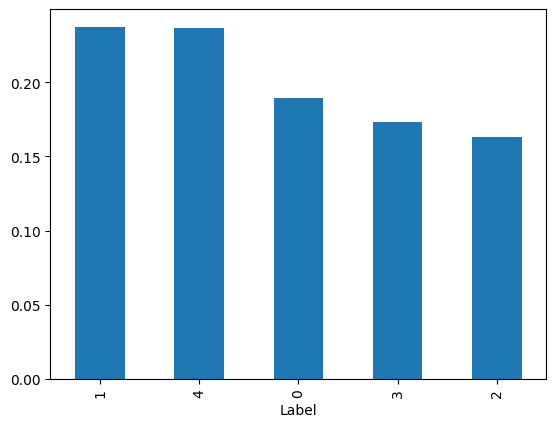

In [21]:
# Ver distribución por clase

data['Label'].value_counts(normalize = True).plot.bar()

En general, hay una distribución casi homogénea.

In [22]:
# Inspección de un texto completo para determinar las tareas de limpieza a realizar
data.Text[0]

'Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour\'s bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n  - A freeze on petrol duty \n  - An extension of tax credit scheme for poorer families \n  - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifestos. Ten years ago, buyers had a much g

Según lo que observa, se requiere, eliminar signos de  puntuación, números, doble caracter de línea. Además de colocar en minúscula y remover stopwords.


In [23]:
# Importar librerías necesarias:

import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from preprocessing import remove_urls, remove_punctuation
from preprocessing import remove_numbers, replace_strings
from preprocessing import remove_stopwords, lemmatizer_eng

ImportError: cannot import name 'remove_urls' from 'preprocessing' (c:\Users\usuario\.conda\envs\env_master\Lib\site-packages\preprocessing\__init__.py)

In [24]:
# Aplicar tareas de limpieza de texto que se identificaron:

#Convertir el texto en minúsculas:
data['clean_text']= data['Text'].apply(lambda x: x.lower())
data.sample(5)

#Eliminar URLs:
data['clean_text']= data['clean_text'].apply(lambda x:remove_urls(x))

#Eliminar signos de puntuación:
PUNCTUATION = """!"#$%&()*+,-./:;<=>?@[\]^_`{|}~"""
data['clean_text']= data['clean_text'].apply(lambda x:remove_punctuation(x, PUNCTUATION))

#Eliminar números:
data['clean_text']= data['clean_text'].apply(lambda x:remove_numbers(x))

# Reemplazar cadenas de texto por equivales (como las contracciones):
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]

patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
data['clean_text']= data['clean_text'].apply(lambda x:replace_strings(x, patterns))

# Tokenizar texto:
wordnet_lemmatizer = WordNetLemmatizer() #defining the object for Lemmatization
data['tokenized_text']= data['clean_text'].apply(lambda x: word_tokenize(x))

#Eliminación de palabras vacias:
STOPWORDS = nltk.corpus.stopwords.words('english') 
STOPWORDS = STOPWORDS + ['mr', 'year']
data['norm_text']= data['tokenized_text'].apply(lambda x: remove_stopwords(x, STOPWORDS))

#Lematizar:
wordnet_lemmatizer = WordNetLemmatizer() # #defining the object for Lemmatization
data['norm_text']=data['norm_text'].apply(lambda x:lemmatizer_eng(x, wordnet_lemmatizer))

# Observar el resultado:

data.sample(5, random_state = 42)

,Text,Label,clean_text,tokenized_text,norm_text
288,"Blair congratulates Bush on win\n \n Tony Blair has said he looks forward to continuing his strong relationship with George Bush and working with him during his second term as president.\n \n Mr Bush's re-election came at a crucial time for a world that was ""fractured, divided and uncertain"", Mr...",0,blair congratulates bush on win\n \n tony blair has said he looks forward to continuing his strong relationship with george bush and working with him during his second term as president\n \n mr bushs reelection came at a crucial time for a world that was fractured divided and uncertain mr blair ...,"[blair, congratulates, bush, on, win, tony, blair, has, said, he, looks, forward, to, continuing, his, strong, relationship, with, george, bush, and, working, with, him, during, his, second, term, as, president, mr, bushs, reelection, came, at, a, crucial, time, for, a, world, that, was, fractur...","[blair, congratulates, bush, win, tony, blair, said, look, forward, continuing, strong, relationship, george, bush, working, second, term, president, bush, reelection, came, crucial, time, world, fractured, divided, uncertain, blair, said, brought, together, added, saying, action, needed, povert..."
2094,China Aviation seeks rescue deal\n \n Scandal-hit jet fuel supplier China Aviation Oil has offered to repay its creditors $220m (Â£117m) of the $550m it lost on trading in oil futures.\n \n The firm said it hoped to pay $100m now and another $120m over eight years. With assets of $200m and liabi...,4,china aviation seeks rescue deal\n \n scandalhit jet fuel supplier china aviation oil has offered to repay its creditors m â£m of the m it lost on trading in oil futures\n \n the firm said it hoped to pay m now and another m over eight years with assets of m and liabilities totalling m it needs ...,"[china, aviation, seeks, rescue, deal, scandalhit, jet, fuel, supplier, china, aviation, oil, has, offered, to, repay, its, creditors, m, â£m, of, the, m, it, lost, on, trading, in, oil, futures, the, firm, said, it, hoped, to, pay, m, now, and, another, m, over, eight, years, with, assets, of, ...","[china, aviation, seek, rescue, deal, scandalhit, jet, fuel, supplier, china, aviation, oil, offered, repay, creditor, â£m, lost, trading, oil, future, firm, said, hoped, pay, another, eight, year, asset, liability, totalling, need, creditor, backing, offer, avoid, going, bankruptcy, trading, sc..."
1801,Yukos heading back to US courts\n \n Russian oil and gas company Yukos is due in a US court on Thursday as it continues to fight for its survival.\n \n The firm is in the process of being broken up by Russian authorities in order to pay a $27bn (Â£14bn) tax bill. Yukos filed for bankruptcy in th...,4,yukos heading back to us courts\n \n russian oil and gas company yukos is due in a us court on thursday as it continues to fight for its survival\n \n the firm is in the process of being broken up by russian authorities in order to pay a bn â£bn tax bill yukos filed for bankruptcy in the us hopi...,"[yukos, heading, back, to, us, courts, russian, oil, and, gas, company, yukos, is, due, in, a, us, court, on, thursday, as, it, continues, to, fight, for, its, survival, the, firm, is, in, the, process, of, being, broken, up, by, russian, authorities, in, order, to, pay, a, bn, â£bn, tax, bill, ...","[yukos, heading, back, u, court, russian, oil, gas, company, yukos, due, u, court, thursday, continues, fight, survival, firm, process, broken, russian, authority, order, pay, bn, â£bn, tax, bill, yukos, filed, bankruptcy, u, hoping, use, international, business, law, halt, forced, sale, key, oi..."
1014,"Satellite mapping aids Darfur relief\n \n Aid workers trying to house, feed and clothe millions of homeless refugees in the Sudanese region of Darfur are getting a helping hand from advanced mapping technology.\n \n A European consortium of companies and university groups known as Respond is wor...",2,satelli

#### Paso 2: Comparación de múltiples clasificadores

In [25]:
###
#1. Crear dos listas. Una con los textos y otra con las etiquetas de valoración
###

# Obtener cadenas transformadas del texto:
transformed_sentences = [' '.join(w) for w in data['norm_text'].to_list()] # unir todos los tokens de un mensaje en un solo string

# Separar los datos:
x_data = transformed_sentences
y_data = data['Label'].to_list()

###
# 2. Preparamos el corpus de entrenamiento y evaluación(tokenizar), y entrenamos al clasificador con Logistic Regression.
###

vectorizer = TfidfVectorizer(
    analyzer= 'word',
 )

X = vectorizer.fit_transform(x_data)

opinions_vector_matrix = X.toarray()

opinions_vector_matrix

###
# 3. Preparamos el corpus de entrenamiento y evaluación, y entrenamos al clasificador con Logistic Regression.
###
random_state_seed = 42
X_train, X_test, y_train, y_test  = train_test_split(
        opinions_vector_matrix,
        y_data,
        train_size=0.80,
        random_state=random_state_seed) #, stratify='Label'


###
# 4. Entrenar y medir el tiempo de ejecución:
###

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score


start_time = time.time()

rf = RandomForestClassifier(random_state = random_state_seed, n_jobs = -1)
nb = MultinomialNB() # Multinomial Naive Baye
knn = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
svm = SVC(random_state = random_state_seed)
gnb = GaussianNB() #Gaussian Naive Bayes
 
models = [rf, nb, knn, svm, gnb] 


accuracy_train = {}
accuracy_test = {}

for model in models:
    name = type(model).__name__
    %time model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    accuracy_train[name] = accuracy_score(y_train, y_pred_train)
    y_pred_test = model.predict(X_test)
    accuracy_test[name] = accuracy_score(y_test, y_pred_test)

end_time = time.time()
execution_time = round(end_time - start_time, 2)
print("Tiempo de ejecución:", execution_time, "segundos")



CPU times: total: 10.5 s
Wall time: 1.24 s
CPU times: total: 188 ms
Wall time: 80 ms
CPU times: total: 15.6 ms
Wall time: 28.2 ms
CPU times: total: 1min 46s
Wall time: 1min 16s
CPU times: total: 219 ms
Wall time: 506 ms
Tiempo de ejecución: 265.13 segundos


**Visualización de las métricas de rendimiento de cada modelo**

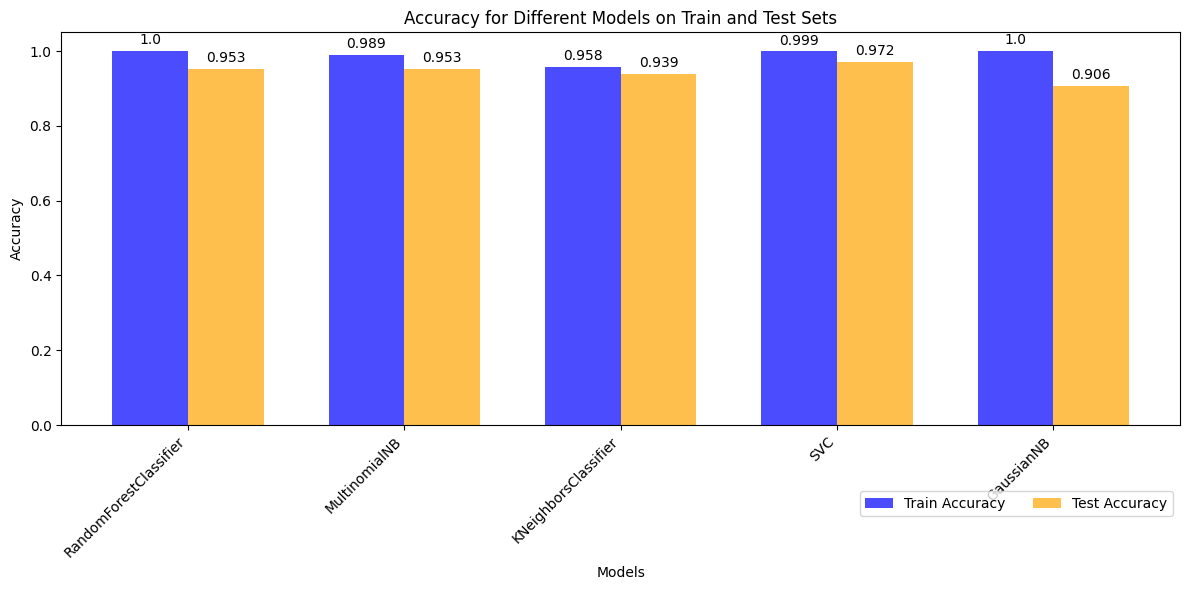

In [26]:
import numpy as np
import matplotlib.pyplot as plt

model_names = list(accuracy_train.keys())
train_accuracies = list(accuracy_train.values())
test_accuracies = list(accuracy_test.values())

ind = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(12, 6))

bars_train = plt.bar(ind - width/2, train_accuracies, width, color='blue', alpha=0.7, label='Train Accuracy')

bars_test = plt.bar(ind + width/2, test_accuracies, width, color='orange', alpha=0.7, label='Test Accuracy')

plt.xticks(ind, model_names, rotation=45, ha='right')

for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')


plt.legend(loc='lower right', bbox_to_anchor=(1.0, -0.25), fancybox=True, ncol=2)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models on Train and Test Sets')

plt.tight_layout()
plt.show()

## 3.2. Clasificación de texto no supervisado - Clustering

Para esta última parte, vamos a usar k-means y HDBSCAN para identificar clusters en el dataset de documentos.

A diferencia de la clasificación multiclase para vectorizar vamos a usar embbeddings creados un modelo de lenguaje neuronal.

De forma específica usaremos el modelo **all-MiniLM-L6-v2** de Sentence-BERT para obtener representaciones semánticas compactas de cada documento.

Vamos a realizar dos experimentos: 1) K-means y 2) HDBSCAN.


### 3.2.1. Clustering con K-means

Algoritmo no supervisado que necesita que se especifique el número de clusters. Para  decidir el número óptimo de clusters podemos usar la métrica de silueta o el método del codo.

1. Método del Codo: Al aumentar el número de clusters, la suma de las distancias cuadráticas dentro de los clusters (WCSS) disminuye. El método del codo busca el punto de inflexión donde la disminución de la WCSS comienza a ser menos pronunciada, formando un "codo" en el gráfico.

2. Método de la Silueta:  Mide qué tan bien asignado está un punto a su propio cluster en comparación con otros clusters. Un valor de silueta cercano a 1 indica que el punto está bien asignado, mientras que un valor cercano a -1 indica que el punto podría estar asignado a otro cluster.   

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
import numpy as np

# Lista de documentos a agrupar:
corpus = transformed_sentences

# 1. Obtener embeddings del corpus usando Sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')  # Modelo eficiente y preciso para textos cortos
embeddings = model.encode(corpus)

# 2. Determinar número óptimo de clusters usando la métrica de silueta (opcional)
silhouette_scores = []
wcss = []
for n_clusters in range(2, 15):  # Probar entre 2 y 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, labels))

c:\Users\usuario\.conda\envs\env_master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


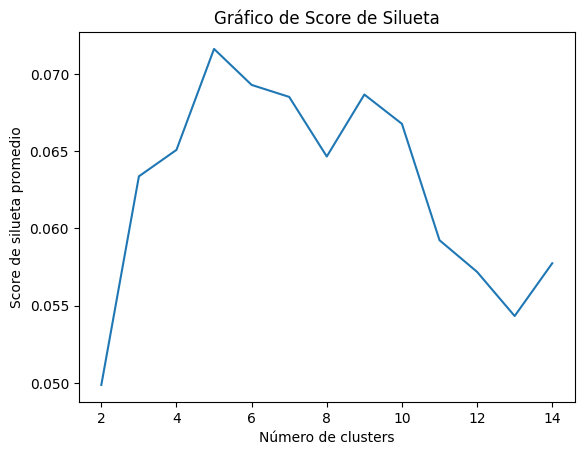

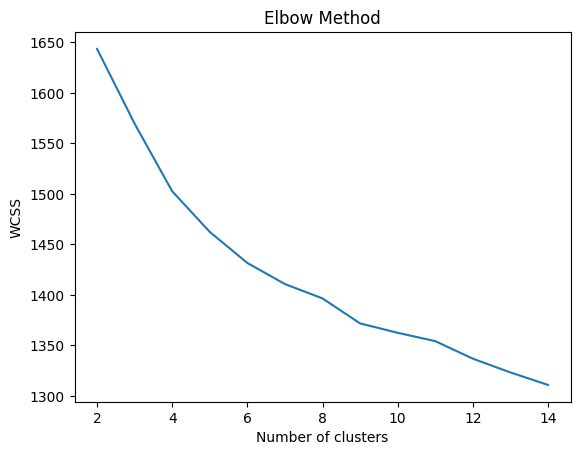

In [28]:
# Visualizar silueta
plt.plot(range(2,15), silhouette_scores)
plt.xlabel("Número de clusters")
plt.ylabel("Score de silueta promedio")
plt.title("Gráfico de Score de Silueta")
plt.show()

#Visualizar codo
plt.plot(range(2, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
    

Según se observa en las dos gráficas, los dos métodos recomiendan que **optimal_clusters** es 8, pero cuando graficamos más adelante se generan áreas superpuestas, por ello en la segunda ocasión probamos 4 clusters.

In [29]:
# Elegir el número óptimo de clusters, utilizando la silueta:
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el índice empieza en 2
print(optimal_clusters) # Primer experimento con 8
optimal_clusters=4 # Segundo experimento con 4

# 3. Aplicar KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)
clusters_list = clusters.tolist()
clusters_list[:20] # Clusters de los primeros 20 documentos

5


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [30]:
# 4. Asignar cada documento a su cluster
data['kmeans'] = clusters_list
data.sample(5, random_state = 123)

,Text,Label,clean_text,tokenized_text,norm_text,kmeans
1252,Technology gets the creative bug\n \n The hi-tech and the arts worlds have for some time danced around each other and offered creative and technical help when required.\n \n Often this help has come in the form of corporate art sponsorship or infrastructure provision. But that dance is growing m...,2,technology gets the creative bug\n \n the hitech and the arts worlds have for some time danced around each other and offered creative and technical help when required\n \n often this help has come in the form of corporate art sponsorship or infrastructure provision but that dance is growing more...,"[technology, gets, the, creative, bug, the, hitech, and, the, arts, worlds, have, for, some, time, danced, around, each, other, and, offered, creative, and, technical, help, when, required, often, this, help, has, come, in, the, form, of, corporate, art, sponsorship, or, infrastructure, provisio...","[technology, get, creative, bug, hitech, art, world, time, danced, around, offered, creative, technical, help, required, often, help, come, form, corporate, art, sponsorship, infrastructure, provision, dance, growing, intimate, hitech, firm, look, creative, industry, inspiration, vice, versa, uk...",3
1798,"Worldcom ex-boss launches defence\n \n Lawyers defending former WorldCom chief Bernie Ebbers against a battery of fraud charges have called a company whistleblower as their first witness.\n \n Cynthia Cooper, WorldCom's ex-head of internal accounting, alerted directors to irregular accounting pr...",4,worldcom exboss launches defence\n \n lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness\n \n cynthia cooper worldcoms exhead of internal accounting alerted directors to irregular accounting practice...,"[worldcom, exboss, launches, defence, lawyers, defending, former, worldcom, chief, bernie, ebbers, against, a, battery, of, fraud, charges, have, called, a, company, whistleblower, as, their, first, witness, cynthia, cooper, worldcoms, exhead, of, internal, accounting, alerted, directors, to, ir...","[worldcom, exboss, launch, defence, lawyer, defending, former, worldcom, chief, bernie, ebbers, battery, fraud, charge, called, company, whistleblower, first, witness, cynthia, cooper, worldcoms, exhead, internal, accounting, alerted, director, irregular, accounting, practice, u, telecom, giant,...",3
891,"Radcliffe enjoys winning comeback\n \n Paula Radcliffe made a triumphant return to competitive running with victory in the New York Marathon.\n \n The Briton, running for the first time since dropping out of the Olympic marathon and 10,000m, held off Kenyan Susan Chepkemei in a thrilling finish....",1,radcliffe enjoys winning comeback\n \n paula radcliffe made a triumphant return to competitive running with victory in the new york marathon\n \n the briton running for the first time since dropping out of the olympic marathon and m held off kenyan susan chepkemei in a thrilling finish the pair ...,"[radcliffe, enjoys, winning, comeback, paula, radcliffe, made, a, triumphant, return, to, competitive, running, with, victory, in, the, new, york, marathon, the, briton, running, for, the, first, time, since, dropping, out, of, the, olympic, marathon, and, m, held, off, kenyan, susan, chepkemei,...","[radcliffe, enjoys, winning, comeback, paula, radcliffe, made, triumphant, return, competitive, running, victory, new, york, marathon, briton, running, first, time, since, dropping, olympic, marathon, held, kenyan, susan, chepkemei, thrilling, finish, pair, locked, together, last, mile, radcliff...",0
1561,"Charity single for quake relief\n \n Singers including Sir Cliff Richard and Boy George are recording a charity single to help raise funds for victims of the Asian tsunami.\n \n They hope the song will raise more than Â£2m for the relief fund. The song, titled Grief Never Grows Old and described.

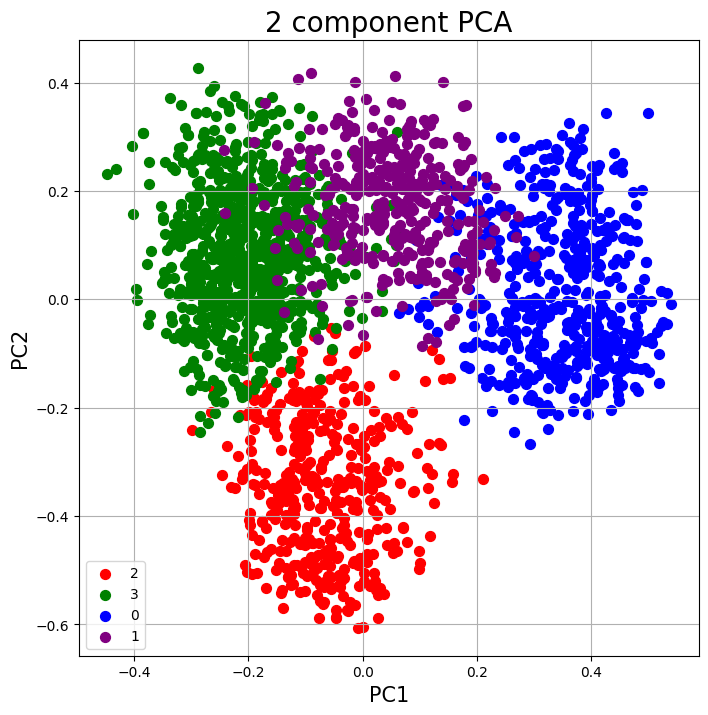

In [31]:
# Visualizamos cada documento con su cluster (según k-means)
from sklearn.decomposition import PCA

# Reducción de dimensionalidad a 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings) # Reducir la dimensionalidad

# Crear un DataFrame
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

# Agregar las etiquetas de cluster
finalDf = pd.concat([principalDf, pd.DataFrame({'kmeans': clusters})], axis = 1)

# Visualizar los clusters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = data['kmeans'].unique()
colors = ['red', 'green', 'blue', 'purple']#, 'orange', 'brown', 'pink', 'gray']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['kmeans'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

### 3.2.1 Aplicando HDBSCAN


<b>Parámetros clave:</b>
- min_cluster_size: El tamaño mínimo de un cluster.
- min_samples: El número mínimo de puntos dentro de un radio para formar un cluster.

<b>Ventajas de HDBSCAN sobre K-means</b>

- No requiere especificar el número de clusters: HDBSCAN encuentra el número de clusters de forma automática.

- Identifica outliers: Los puntos que no pertenecen a ningún cluster se consideran ruido.


In [41]:
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler

# Aplicar HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=10, min_samples=100)  # Ajustar
labels = hdbscan.fit_predict(embeddings)

# Reducción de dimensionalidad a 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings)

# Crear un DataFrame
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

# Agregar las etiquetas de cluster
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster': labels})], axis = 1)
finalDf

,PC1,PC2,cluster
0,-0.079328,-0.495405,0
1,0.042661,-0.314705,-1
2,-0.180966,-0.443485,0
3,-0.076387,-0.449675,0
4,0.125396,-0.375452,-1
...,...,...,...
2122,-0.251899,0.183201,-1
2123,-0.169076,0.146462,-1
2124,-0.248515,-0.164657,-1
2125,-0.188979,0.083728,-1


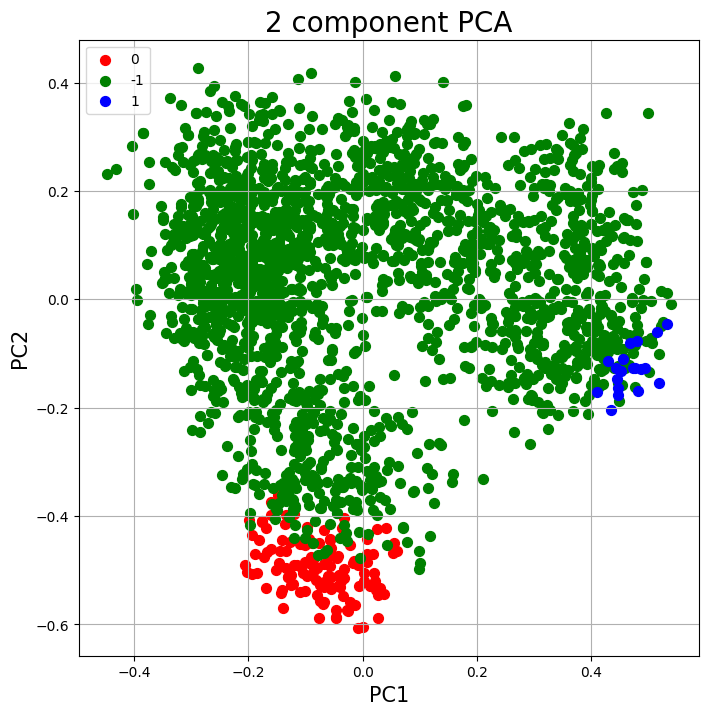

In [42]:
# Visualizar los clusters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = finalDf['cluster'].unique()
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

In [37]:
data['hdbscan'] = labels
data.sample(7, random_state=42)

,Text,Label,clean_text,tokenized_text,norm_text,kmeans,hdbscan
288,"Blair congratulates Bush on win\n \n Tony Blair has said he looks forward to continuing his strong relationship with George Bush and working with him during his second term as president.\n \n Mr Bush's re-election came at a crucial time for a world that was ""fractured, divided and uncertain"", Mr...",0,blair congratulates bush on win\n \n tony blair has said he looks forward to continuing his strong relationship with george bush and working with him during his second term as president\n \n mr bushs reelection came at a crucial time for a world that was fractured divided and uncertain mr blair ...,"[blair, congratulates, bush, on, win, tony, blair, has, said, he, looks, forward, to, continuing, his, strong, relationship, with, george, bush, and, working, with, him, during, his, second, term, as, president, mr, bushs, reelection, came, at, a, crucial, time, for, a, world, that, was, fractur...","[blair, congratulates, bush, win, tony, blair, said, look, forward, continuing, strong, relationship, george, bush, working, second, term, president, bush, reelection, came, crucial, time, world, fractured, divided, uncertain, blair, said, brought, together, added, saying, action, needed, povert...",2,-1
2094,China Aviation seeks rescue deal\n \n Scandal-hit jet fuel supplier China Aviation Oil has offered to repay its creditors $220m (Â£117m) of the $550m it lost on trading in oil futures.\n \n The firm said it hoped to pay $100m now and another $120m over eight years. With assets of $200m and liabi...,4,china aviation seeks rescue deal\n \n scandalhit jet fuel supplier china aviation oil has offered to repay its creditors m â£m of the m it lost on trading in oil futures\n \n the firm said it hoped to pay m now and another m over eight years with assets of m and liabilities totalling m it needs ...,"[china, aviation, seeks, rescue, deal, scandalhit, jet, fuel, supplier, china, aviation, oil, has, offered, to, repay, its, creditors, m, â£m, of, the, m, it, lost, on, trading, in, oil, futures, the, firm, said, it, hoped, to, pay, m, now, and, another, m, over, eight, years, with, assets, of, ...","[china, aviation, seek, rescue, deal, scandalhit, jet, fuel, supplier, china, aviation, oil, offered, repay, creditor, â£m, lost, trading, oil, future, firm, said, hoped, pay, another, eight, year, asset, liability, totalling, need, creditor, backing, offer, avoid, going, bankruptcy, trading, sc...",3,-1
1801,Yukos heading back to US courts\n \n Russian oil and gas company Yukos is due in a US court on Thursday as it continues to fight for its survival.\n \n The firm is in the process of being broken up by Russian authorities in order to pay a $27bn (Â£14bn) tax bill. Yukos filed for bankruptcy in th...,4,yukos heading back to us courts\n \n russian oil and gas company yukos is due in a us court on thursday as it continues to fight for its survival\n \n the firm is in the process of being broken up by russian authorities in order to pay a bn â£bn tax bill yukos filed for bankruptcy in the us hopi...,"[yukos, heading, back, to, us, courts, russian, oil, and, gas, company, yukos, is, due, in, a, us, court, on, thursday, as, it, continues, to, fight, for, its, survival, the, firm, is, in, the, process, of, being, broken, up, by, russian, authorities, in, order, to, pay, a, bn, â£bn, tax, bill, ...","[yukos, heading, back, u, court, russian, oil, gas, company, yukos, due, u, court, thursday, continues, fight, survival, firm, process, broken, russian, authority, order, pay, bn, â£bn, tax, bill, yukos, filed, bankruptcy, u, hoping, use, international, business, law, halt, forced, sale, key, oi...",3,-1
1014,"Satellite mapping aids Darfur relief\n \n Aid workers trying to house, feed and clothe millions of homeless refugees in the Sudanese region of Darfur are getting a helping hand from advanced mapping technology.\n \n A European consortium of companies and university groups known a

In [38]:
print(data.iloc[414][['Label', 'kmeans', 'hdbscan']]) # Politics?

data.iloc[414]['Text']

Label       1
kmeans      0
hdbscan    -1
Name: 428, dtype: object


"O'Driscoll out of Scotland game\n \n Ireland captain Brian O'Driscoll has been ruled out of Saturday's RBS Six Nations clash against Scotland.\n \n O'Driscoll was originally named in the starting line-up but has failed to recover from the hamstring injury he picked up in the win over Italy. His replacement will be named after training on Friday morning. Fellow centre Gordon D'Arcy is also struggling with a hamstring injury and he will undergo a fitness test on Friday to see if he can play.\n \n Kevin Maggs would be an obvious replacement at centre while Shane Horgan could also be moved from wing. Ulster wing Tommy Bowe could also be asked to travel with the squad to Scotland as a precautionary measure. The only other change to the Ireland side sees Wasps flanker Johnny O'Connor replacing Denis Leamy. O'Connor will be winning his third cap after making his debut in the victory over South Africa last November.\n \n : Murphy, Horgan, TBC, D'Arcy, Hickie, O'Gara, Stringer, Corrigan, Byrne